In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Загружаем данные
file_path = "../npz/BTCUSD_1T.npz"
data = np.load(file_path, allow_pickle=True)
if 'data' in data:
    raw_data = data['data']
else:
    raise ValueError("Файл не содержит ключа 'data'")
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
df = pd.DataFrame(raw_data, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# При необходимости можно ограничить число точек:
#df = df.iloc[:50* 1000]


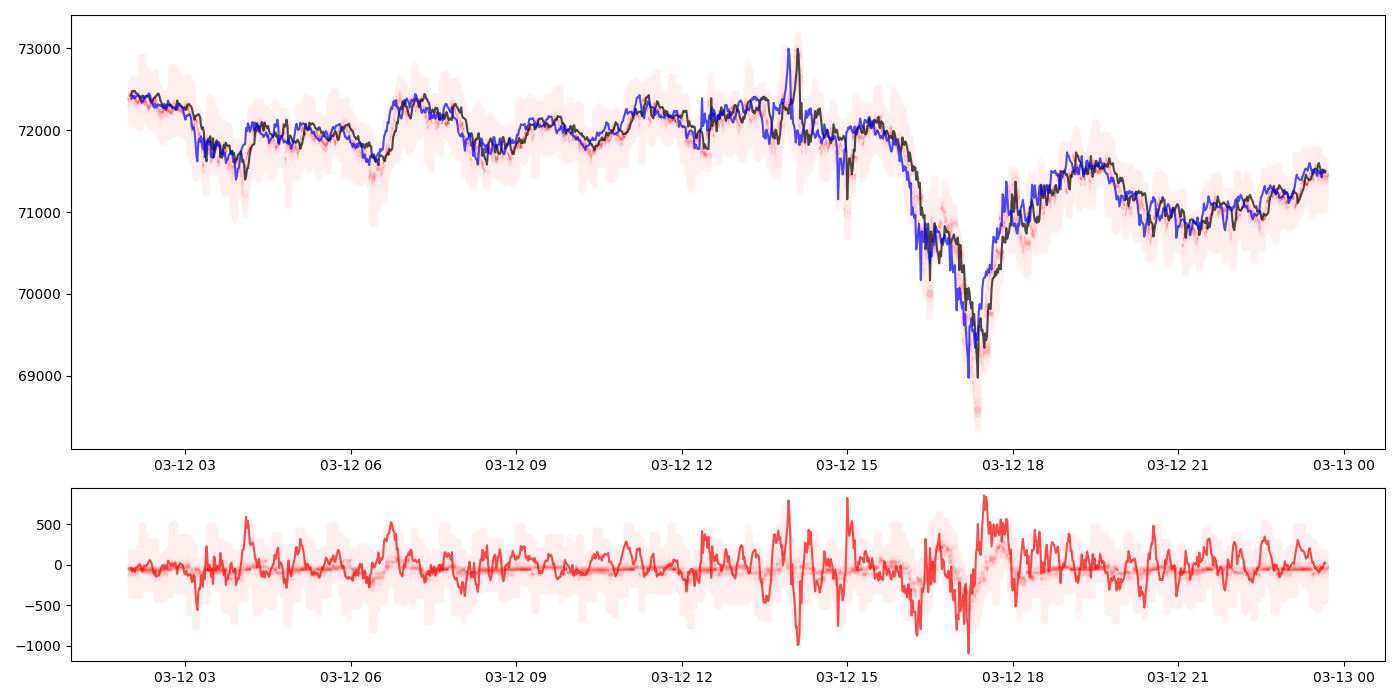

In [27]:
from matplotlib.colors import LinearSegmentedColormap

########################################################################
# Вспомогательная функция для перевода (x, y, z) в индексы сетки с использованием объекта grid_size
def to_grid_3d(xx, yy, zz, bounds, grid_size):
    """
    Преобразует координаты (xx, yy, zz) в индексы сетки.
    
    :param xx, yy, zz: координаты точки.
    :param bounds: кортеж (x_min, x_max, y_min, y_max, z_min, z_max).
    :param grid_size: словарь с ключами 'x', 'y', 'z' для размеров сетки.
    :return: кортеж (i_x, i_y, i_z) – индексы точки в сетке.
    """
    (x_min, x_max, y_min, y_max, z_min, z_max) = bounds
    i_x = int((xx - x_min) / (x_max - x_min) * (grid_size['x'] - 1))
    i_y = int((yy - y_min) / (y_max - y_min) * (grid_size['y'] - 1))
    i_z = int((zz - z_min) / (z_max - z_min) * (grid_size['z'] - 1))
    # return (x_min + i_x * (grid_size['x'] - 1) / (x_max - x_min), i_y, i_z)
    return (i_x, i_y, i_z)

def get_transitions(df, window_short, window_long, tau, grid_size):
    """
    Разбивает фазовое пространство (x, y, z) на 3D-сетку и заполняет map переходов.
    Здесь:
      x = price_diff (0-я производная сглаженного относительного изменения цены)
      y = первая производная (относительное изменение скорости)
      z = вторая производная (ускорение изменения относительного изменения)
    
    :param df: DataFrame с ценами.
    :param window_short: короткое окно сглаживания.
    :param window_long: длинное окно сглаживания.
    :param tau: шаг прогноза (в баров).
    :param grid_size: словарь с размерами сетки, например {'x':50, 'y':50, 'z':50}.
    :return: (cache, bounds), где
             cache = { (i_x, i_y, i_z) -> { future_x: count } }
             bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    """
    polyorder = 3

    # Сглаживаем цену
    smoothed_short = savgol_filter(df['close'].values, window_short, polyorder)
    smoothed_long  = savgol_filter(df['close'].values, window_long, polyorder)
    
    # Относительное изменение (в процентах)
    rel_price_diff = (smoothed_short - smoothed_long) / smoothed_long

    # Вычисляем три координаты: 
    # x = базовый сигнал (разность),
    # y = первая производная,
    # z = вторая производная.
    x = savgol_filter(rel_price_diff, window_short, polyorder, deriv=0)
    y = savgol_filter(rel_price_diff, window_short, polyorder, deriv=1)
    z = savgol_filter(rel_price_diff, window_short, polyorder, deriv=2)
    
    # Границы фазового пространства
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    z_min, z_max = np.min(z), np.max(z)
    bounds = (x_min, x_max, y_min, y_max, z_min, z_max)
    
    transitions = {}  # { (i_x, i_y, i_z) -> { future_x: count } }
    n = len(x) - tau
    for t in range(n):
        cell_now = to_grid_3d(x[t], y[t], z[t], bounds, grid_size)
        cell_future = to_grid_3d(x[t+tau], y[t+tau], z[t+tau], bounds, grid_size)
        future_x = cell_future[0]  # Используем только x-компоненту будущей ячейки
        if cell_now not in transitions:
            transitions[cell_now] = {}
        if future_x not in transitions[cell_now]:
            transitions[cell_now][future_x] = 0
        transitions[cell_now][future_x] += 1
    # counts to probabilities
    for cell_now in transitions:
        cell_now_transitions = transitions[cell_now]
        total = sum(cell_now_transitions.values())
        for future_x in cell_now_transitions:
            cell_now_transitions[future_x] /= total
    return transitions, bounds

########################################################################
# Функция визуализации прогноза с использованием 3D-кэша (новый формат кеша)
def plot_price_forecast_with_heatmap_3d(df, transitions, bounds, windows, tau, start_idx, end_idx, grid_size):
    """
    Строит график цен и наносит прогноз в виде точек,
    где цвет отражает частоту перехода. Для обратного прогнозирования используется только x-компонента из 3D-кэша.
    
    :param df: DataFrame с ценами (тестовая выборка).
    :param transitions: [{}] transitions in phase space for each averaging window.
    :param bounds: [(x_min, x_max, y_min, y_max, z_min, z_max)] – min,max values for the phase spaces.
    :param windows: [(window_short, window_long)] window sizes that were used to build phase space.
    :param tau: forecase distance.
    :param start_idx: начало прогноза.
    :param end_idx: конец прогноза.
    :param grid_size: словарь с размерами сетки, например {'x':200, 'y':100, 'z':10}.
    """
    polyorder = 3

    # phase space coordinates for each window
    xs = []
    ys = []
    zs = []
    for w in range(len(windows)):
        window_short, window_long = windows[w]
        smoothed_short = savgol_filter(df['close'].values, window_short, polyorder)
        smoothed_long  = savgol_filter(df['close'].values, window_long, polyorder)
        rel_price_diff = (smoothed_short - smoothed_long) / smoothed_long
        # calc phase space coordinates x, y, z
        x = savgol_filter(rel_price_diff, window_short, polyorder, deriv=0)
        y = savgol_filter(rel_price_diff, window_short, polyorder, deriv=1)
        z = savgol_filter(rel_price_diff, window_short, polyorder, deriv=2)
        # append coordinates in phase space for window w
        xs.append(x)
        ys.append(y)
        zs.append(z)

    # Используем ту же функцию to_grid_3d для преобразования
    def to_grid(xx, yy, zz, bounds):
        return to_grid_3d(xx, yy, zz, bounds, grid_size)

    future_points = []
    future_probs = []
    N = len(x)
    # тут дальше начинается сложное место.
    # надо для каждого момента времени t взять прогнозы от разных маштабов (кешей) и объединить их.
    # для этого:
    # сделаем функцию, которая будет принимать на вход два прогноза и объединять их в один.
    #    потом применять эту функцию к каждой паре прогнозов. но тут тоже есть проблема - как сохранять объедененные прогнозы.
    #    если просто брать сдвиг цены одного маштбара, прибавлять к нему сдвиг цены другого масштаба и сохранять в 
    #    дикшенери, то такой дикшенери будет быстро расти в размере. например, если у нас 50 ячеек в каждом масштабе, а 
    #    масштабов 5 штук, то будет 50^5 ячеек = 312500000 ячеек. второй вариант - сразу посчитать разброс прогнозов и
    #    сделать для него сетку. но сетку видимо придется делать с большим количеством ячеек, иначе округления прогнозов
    #    на каждом слиянии будут давать слишком большие сдвиги.
    def merge(forecasts1, x_ranges1, grid_size1, forecasts2, x_ranges2, grid_size2, result_x_ranges, result_grid_size):
        (x_min1, x_max1) = x_ranges1
        (x_min2, x_max2) = x_ranges2
        (x_min, x_max) = result_x_ranges
        result = {}
        for (future_x1, probability1) in forecasts1.items():
            for (future_x2, probability2) in forecasts2.items():
                future_price_diff1 = x_min1 + (future_x1 / (grid_size1 - 1)) * (x_max1 - x_min1)
                future_price_diff2 = x_min2 + (future_x2 / (grid_size2 - 1)) * (x_max2 - x_min2)
                future_price_diff = future_price_diff1 + future_price_diff2
                future_x = int((future_price_diff - x_min) / (x_max - x_min) * (result_grid_size - 1))
                probability = probability1 * probability2
                if future_x not in result:
                    result[future_x] = 0
                result[future_x] += probability
        return result
    
    (x_min, x_max) = (0, 0)
    for w in range(len(windows)):
        (x_min_w, x_max_w, _, _, _, _) = bounds[w]
        # just sum mins and maxes because if for window 1 min movement was x_min1 and for window 2 min movement was x_min2
        # then for merged window min movement will be x_min1+x_min2. Note x_min1 and x_min2 can be negative and most probably will be.
        x_min += x_min_w
        x_max += x_max_w
    result_grid_size = 200
    for t in range(start_idx, min(end_idx, N - tau)):
        total_transitions = {}
        total_transitions[int(result_grid_size*(0 - x_min)/(x_max - x_min))] = 1
        for w in range(len(windows)):
            x, y, z = xs[w], ys[w], zs[w]
            w_bounds = bounds[w]
            cell_now = to_grid(x[t], y[t], z[t], w_bounds)
            (x_min_w, x_max_w, _, _, _, _) = w_bounds
            w_transitions = transitions[w]
            if cell_now in w_transitions:
                cell_now_transitions = w_transitions[cell_now]
                total_transitions = merge(total_transitions, (x_min, x_max), result_grid_size, cell_now_transitions, (x_min_w, x_max_w), grid_size['x'], (x_min, x_max), result_grid_size)
        for future_x, prob in total_transitions.items():
            # Обратное преобразование: переводим future_x обратно в значение x
            # reverse transformation: index in the grid future_x into price delta movement future_price_diff
            future_price_diff = x_min + (future_x / (result_grid_size - 1)) * (x_max - x_min)
            # rough hypothesis for forecast: future_price_diff for the largest window will be close to zero, 
            # hence we can just add the price change to the current df['close'].
            # future_price_diff is measured in relative price change, 
            # so we need to multiply it by smoothed_long[t] to get the future price.
            future_price = future_price_diff * smoothed_long[t] + df['close'].iloc[t]
            current_time = df.index[t]
            future_points.append((current_time, future_price, future_price_diff * smoothed_long[t]))
            future_probs.append(prob)

    fig, (ax, ax2) = plt.subplots(
        2,  # Два графика (2 строки)
        1,  # Один столбец
        figsize=(14, 7),  # Общий размер
        gridspec_kw={'height_ratios': [5, 2]}
    )
    ax.plot(df.index[start_idx:end_idx], df['close'].iloc[start_idx:end_idx], label="Цена BTC/USD", color='black', alpha=0.7)
    ax.plot(df.index[start_idx:end_idx], df['close'].shift(-tau).iloc[start_idx:end_idx], label="Цена (tau вперед)", color='blue', alpha=0.7)
    ax2.plot(df.index[start_idx:end_idx], (df['close'].shift(-tau) - df['close'])[start_idx:end_idx], label="price diff", color='red', alpha=0.7)
    if future_points:
        future_times, future_prices, future_diffs = zip(*future_points)
        # Создаём одноцветный красный градиент от светлого к насыщенному
        red_gradient = LinearSegmentedColormap.from_list("red_gradient", ["#FFEEEE", "#FF0000"])
        ax.scatter(future_times, future_prices, c=future_probs, cmap=red_gradient, alpha=0.5, s=19)
        ax2.scatter(future_times, future_diffs, c=future_probs, cmap=red_gradient, alpha=0.5, s=19)
    plt.tight_layout()
    plt.show()

# Пример: разделим данные на train/test (80/20)
N = len(df)
train_size = int(0.8 * N)
train_df = df.iloc[:train_size]
test_df  = df.iloc[train_size:]

grid_size = {'x': 50, 'y': 20, 'z': 10}
tau = 10

caches = []
bounds = []
windows = []

window_short = 31
window_long  = 61
cache_3d, bounds_3d = get_transitions(train_df, window_short, window_long, tau, grid_size)
caches.append(cache_3d)
bounds.append(bounds_3d)
windows.append((window_short, window_long))

window_short = 61
window_long  = 121
cache_3d, bounds_3d = get_transitions(train_df, window_short, window_long, tau, grid_size)
caches.append(cache_3d)
bounds.append(bounds_3d)
windows.append((window_short, window_long))

# window_short = 121
# window_long  = 241
# cache_3d, bounds_3d = get_transitions(train_df, window_short, window_long, tau, grid_size)
# caches.append(cache_3d)
# bounds.append(bounds_3d)
# windows.append((window_short, window_long))

# window_short = 241
# window_long  = 481
# cache_3d, bounds_3d = get_transitions(train_df, window_short, window_long, tau, grid_size)
# caches.append(cache_3d)
# bounds.append(bounds_3d)
# windows.append((window_short, window_long))

start_idx=window_long
end_idx=window_long + 1300
plot_price_forecast_with_heatmap_3d(test_df, caches, bounds, windows, tau, start_idx, end_idx, grid_size)

In [ ]:
window_short = 61
window_long  = 121
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)
start_idx=window_long
end_idx=window_long + 300
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size)


In [ ]:
window_short = 121
window_long  = 241
print(f"tau={tau}")
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)
start_idx=window_long
end_idx=window_long + 300
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size)

In [ ]:
window_short = 241
window_long  = 481
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)
start_idx=window_long
end_idx=window_long + 1300
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size)

In [ ]:
window_short = 481
window_long  = 480*2+1
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)
start_idx=window_long
end_idx=window_long + 3000
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size)

In [ ]:
tau = 150
window_short = 481
window_long  = 480*2+1
cache_3d, bounds_3d = build_phase_space_grid_3d(train_df, window_short, window_long, tau, grid_size)

In [ ]:
shift = window_long + 2500
start_idx=shift
end_idx=shift+3000
plot_price_forecast_with_heatmap_3d(test_df, cache_3d, bounds_3d, window_short, window_long, tau, start_idx, end_idx, grid_size)